## 3. Modelado

Importación de librerías

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

#preprocesamiento
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA

#Machine Learning Algorithms (MLA)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
import joblib

#metricas
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from imblearn.pipeline import Pipeline

Lectura de datos

In [6]:
df = pd.read_csv('../datos_depurados/dataset_to_train.csv')

In [7]:
df.drop(['Unnamed: 0', 'nit_num_oblig_id'], axis=1, inplace=True)

In [8]:
df.shape

(455372, 44)

Se debe generar el conjunto de las variables independientes y la variable dependiente

In [9]:
X = df.drop(['y'],axis=1)
Y = df['y']

Aplicación de técnica de One hot encoding para llevar las variables categóricas a numéricas

In [10]:
columns_to_fit = [variable for variable in X.columns if X[variable].dtype == 'object']
enc = OneHotEncoder(drop=None, sparse_output=False).fit(df.loc[:, columns_to_fit])

Se guarda el objeto encoder para aplicarse en producción

In [7]:
joblib.dump(enc, 'encoder.pkl')

['encoder.pkl']

Se generan nuevamente el conjunto de X y Y ya con las variables resultantes del One hot encoding

In [11]:
column_names = enc.get_feature_names_out(columns_to_fit)
encoded_variables = pd.DataFrame(enc.transform(df.loc[:, columns_to_fit]), columns=column_names)

In [12]:
df = df.drop(columns_to_fit, axis=1)
df = pd.concat([df, encoded_variables], axis=1)

In [13]:
X = df.drop(['y'],axis=1)
Y = df['y']

Se estandarizan las variables utilizando la técnica de Min Max Scaler, la cual lleva todo a rangos entre 0 y 1

In [9]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(X)

Se guarda el objeto scaler para utilizarse en producción

In [12]:
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [10]:
norm = scaler.transform(X)
x_norm = pd.DataFrame(norm,index=df.index,columns=X.columns)

Se genera el conjunto de datos de entrenamiento y testeo, empleando un 20% para testeo

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20,random_state=42, stratify=Y)

### Gráfica de valores a clasificar

Se utilizará la técnica de Principal Component Analysis para extraer las dos componentes principales y así poder graficar los datos que se desean clasificar, esto con el fin de generar una visualización del problema a resolver

In [15]:
pca = PCA(n_components=2)
pca.fit(X_test)
X_pca = pca.transform(X_test)

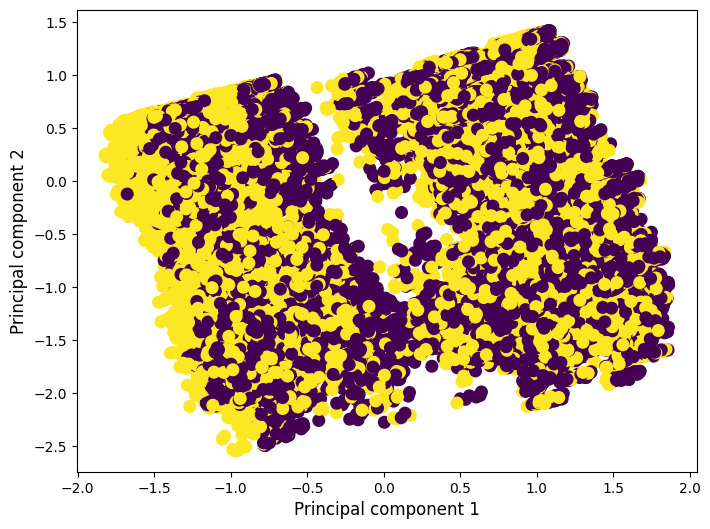

In [17]:
plt.figure(figsize=(8,6),facecolor='w', edgecolor='k',num=1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_test, s=70, cmap='viridis')
plt.xlabel('Principal component 1', fontsize=12)
plt.ylabel('Principal component 2', fontsize=12)
plt.show()

El objetivo es encontrar el mejor modelo de Machine Learning que logre idenfiticar el patrón de los datos de aceptación y rechazo de opción de pago (valores morados y amarillos)

## Modelos de Machine Learning

Se escogieron 7 modelos incialmente para entrenarse, de estos 7 se identificará el mejor modelo de acuerdo a las métricas de F1 Score al cuale se le tunearán los hiper parámetros para encontrar los óptimos, y finalmente obtener el mejor modelo que sea posteriormente desplegado en unA API

La siguiente función entrena cada uno de los 6 modelos pasados por parámetro

In [15]:
def train_model(model):
    dist_models = {
        'LogisticRegression': LogisticRegression(),
        'KNeighborsClassifier': KNeighborsClassifier(),
        'DecisionTreeClassifier': DecisionTreeClassifier(),
        'RandomForestClassifier': RandomForestClassifier(),
        'GradientBoostingClassifier': GradientBoostingClassifier(),
        'AdaBoostClassifier': AdaBoostClassifier()
    }
    model = dist_models[model]
    pipeline=Pipeline(steps=[('m', model)])
    pipeline.fit(X_train,y_train,)
    pipe_log_train = pipeline.predict(X_train)
    pipe_log_test = pipeline.predict(X_test)
    report = classification_report(y_test,pipe_log_test,output_dict=True)
    report_pipe = pd.DataFrame(report).transpose()
    return report

Regresión Logística

In [16]:
train_model('LogisticRegression')

/home/sergioq2/AI/Bancolombia/ml_venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'0': {'precision': 0.7858188472095151,
  'recall': 0.9059170973526,
  'f1-score': 0.8416050169026505,
  'support': 47405.0},
 '1': {'precision': 0.8775566231983528,
  'recall': 0.731967025417907,
  'f1-score': 0.7981771646170173,
  'support': 43670.0},
 'accuracy': 0.8225089212187757,
 'macro avg': {'precision': 0.831687735203934,
  'recall': 0.8189420613852535,
  'f1-score': 0.8198910907598339,
  'support': 91075.0},
 'weighted avg': {'precision': 0.8298066449304323,
  'recall': 0.8225089212187757,
  'f1-score': 0.8207815822684084,
  'support': 91075.0}}

K vecinos más cercanos

In [17]:
train_model('KNeighborsClassifier')

{'0': {'precision': 0.7824366039808345,
  'recall': 0.871532538761734,
  'f1-score': 0.8245848634839533,
  'support': 47405.0},
 '1': {'precision': 0.8408758361204013,
  'recall': 0.7369361117471949,
  'f1-score': 0.7854824143906666,
  'support': 43670.0},
 'accuracy': 0.8069942355201757,
 'macro avg': {'precision': 0.8116562200506179,
  'recall': 0.8042343252544644,
  'f1-score': 0.80503363893731,
  'support': 91075.0},
 'weighted avg': {'precision': 0.8104579190237647,
  'recall': 0.8069942355201757,
  'f1-score': 0.8058354377150394,
  'support': 91075.0}}

Árbol de decisión

In [18]:
train_model('DecisionTreeClassifier')

{'0': {'precision': 0.8547894927768175,
  'recall': 0.8450163484864466,
  'f1-score': 0.8498748249671151,
  'support': 47405.0},
 '1': {'precision': 0.8338233963629784,
  'recall': 0.8441722005953743,
  'f1-score': 0.838965886074509,
  'support': 43670.0},
 'accuracy': 0.8446115838594564,
 'macro avg': {'precision': 0.844306444569898,
  'recall': 0.8445942745409105,
  'f1-score': 0.8444203555208121,
  'support': 91075.0},
 'weighted avg': {'precision': 0.8447363560170882,
  'recall': 0.8446115838594564,
  'f1-score': 0.8446440441662354,
  'support': 91075.0}}

Bosques aleatorios

In [16]:
train_model('RandomForestClassifier')

{'0': {'precision': 0.8725057596938576,
  'recall': 0.942685370741483,
  'f1-score': 0.9062389097877777,
  'support': 47405.0},
 '1': {'precision': 0.9318312968863688,
  'recall': 0.850469429814518,
  'f1-score': 0.8892932824116753,
  'support': 43670.0},
 'accuracy': 0.8984682953609663,
 'macro avg': {'precision': 0.9021685282901132,
  'recall': 0.8965774002780005,
  'f1-score': 0.8977660960997265,
  'support': 91075.0},
 'weighted avg': {'precision': 0.9009520535088119,
  'recall': 0.8984682953609663,
  'f1-score': 0.8981135675147676,
  'support': 91075.0}}

Gradient Boosting

In [23]:
train_model('GradientBoostingClassifier')

{'0': {'precision': 0.8238360428268737,
  'recall': 0.9268220651829976,
  'f1-score': 0.872299872935197,
  'support': 47405.0},
 '1': {'precision': 0.9080913522679102,
  'recall': 0.7848637508587131,
  'f1-score': 0.8419927776549487,
  'support': 43670.0},
 'accuracy': 0.8587537743617897,
 'macro avg': {'precision': 0.8659636975473919,
  'recall': 0.8558429080208554,
  'f1-score': 0.8571463252950728,
  'support': 91075.0},
 'weighted avg': {'precision': 0.8642360358358231,
  'recall': 0.8587537743617897,
  'f1-score': 0.8577677746547858,
  'support': 91075.0}}

Adam Boosting

In [24]:
train_model('AdaBoostClassifier')

/home/sergioq2/AI/Bancolombia/banc_venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'0': {'precision': 0.8080019380567254,
  'recall': 0.9146503533382555,
  'f1-score': 0.8580248745881445,
  'support': 47405.0},
 '1': {'precision': 0.8918557720578408,
  'recall': 0.764071444927868,
  'f1-score': 0.8230331882145456,
  'support': 43670.0},
 'accuracy': 0.84244853143014,
 'macro avg': {'precision': 0.8499288550572831,
  'recall': 0.8393608991330618,
  'f1-score': 0.840529031401345,
  'support': 91075.0},
 'weighted avg': {'precision': 0.8482094256310181,
  'recall': 0.84244853143014,
  'f1-score': 0.8412465386679132,
  'support': 91075.0}}

LightGBM

In [24]:
model = LGBMClassifier(
    boosting_type='gbdt', 
    num_leaves=31, 
    max_depth=-1, 
    learning_rate=0.1, 
    n_estimators=100,
    objective='binary',
    random_state=42
)

model.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 174680, number of negative: 189617
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025365 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4950
[LightGBM] [Info] Number of data points in the train set: 364297, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.479499 -> initscore=-0.082051
[LightGBM] [Info] Start training from score -0.082051


LGBMClassifier(objective='binary', random_state=42)

In [25]:
pipeline=Pipeline(steps=[('m', model)])
pipeline.fit(X_train,y_train,)
pipe_log_train = pipeline.predict(X_train)
pipe_log_test = pipeline.predict(X_test)
report = classification_report(y_test,pipe_log_test,output_dict=True)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 174680, number of negative: 189617
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021470 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4950
[LightGBM] [Info] Number of data points in the train set: 364297, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.479499 -> initscore=-0.082051
[LightGBM] [Info] Start training from score -0.082051


In [26]:
report

{'0': {'precision': 0.8456401450104942,
  'recall': 0.9349224765320114,
  'f1-score': 0.8880428793267545,
  'support': 47405.0},
 '1': {'precision': 0.9202120781068149,
  'recall': 0.8147469658804671,
  'f1-score': 0.8642740025505556,
  'support': 43670.0},
 'accuracy': 0.8772989294537469,
 'macro avg': {'precision': 0.8829261115586546,
  'recall': 0.8748347212062393,
  'f1-score': 0.8761584409386551,
  'support': 91075.0},
 'weighted avg': {'precision': 0.8813970082365862,
  'recall': 0.8772989294537469,
  'f1-score': 0.8766458236164432,
  'support': 91075.0}}

Optimización de hiper parámetros del RandomForest

In [ ]:
rf_para = {'n_estimators':[10,20,30,40,50,60,100], 'criterion':['gini','entropy'],
           'max_depth':[4,5,6,7,8],
           'bootstrap':[True,False], 'min_samples_split':[2,3,4,5,6],
           'min_samples_leaf':[1,2,3,4,5]}
model = GridSearchCV(RandomForestClassifier(), rf_para, cv=3, n_jobs=-1)
pipeline_rf=Pipeline(steps=[('m', model)])
pipeline_rf.fit(X_train,y_train)
pipe_rf_train = pipeline_rf.predict(X_train)
pipe_rf_test = pipeline_rf.predict(X_test)
report = classification_report(y_train,pipe_rf_train,output_dict=True)
report_rf_pipe = pd.DataFrame(report).transpose()
report_rf_pipe

In [ ]:
joblib.dump(pipeline_rf, 'model_classification.pkl')

El mejor modelo de acuerdo a sus resultados de F1_Score fue el LigthGBM

Se presentarán sus métricas de una forma más detallada

In [21]:
pipe_rf_train = pipeline_rf.predict(X_train)
pipe_rf_test = pipeline_rf.predict(X_test)

In [23]:
report = classification_report(y_test,pipe_rf_test,output_dict=True)
report_gb_pipe_test = pd.DataFrame(report).transpose()
report_gb_pipe_test

,precision,recall,f1-score,support
0,0.871554,0.942411,0.905599,47405.000000
1,0.931435,0.849233,0.888436,43670.000000
accuracy,0.897733,0.897733,0.897733,0.897733
macro avg,0.901494,0.895822,0.897018,91075.000000
weighted avg,0.900267,0.897733,0.897370,91075.000000


Se obtiene un F1-Score de 89% para los datos de entrenamiento y test, lo cual no solo indica que es el modelo más preciso y acertado sino que logra tener un balance óptimo en la varianza

#### Matriz de confusión

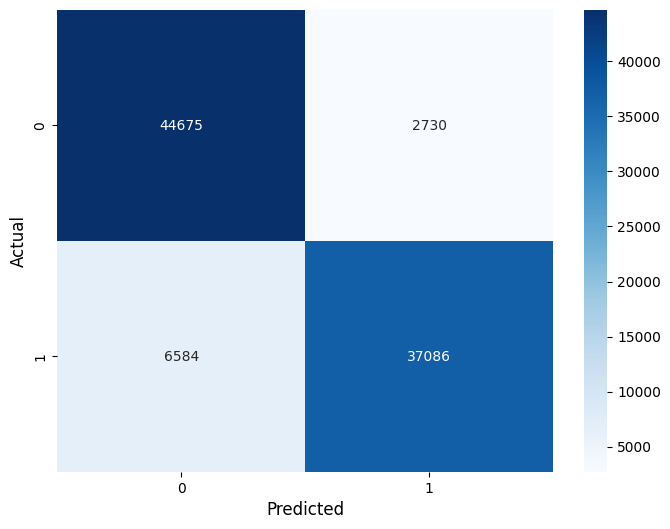

In [24]:
cm = confusion_matrix(y_test, pipe_rf_test)
plt.figure(figsize=(8,6),facecolor='w', edgecolor='k',num=1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.show()  

La matriz da evidencia de que apesar de una precisión por encima del 89%, el modelo aún genera muchos registros mal clasificados, por ejemplo 2730 clientes que el mmodelo predice que aceptará la opción de pago cuando realmente no la aceptaron, y 6584 que el modelo predice que no la aceptarán cuando realmente si lo hicieron. El rendimiento del modelo de podría mejorar aún más con mayor cantidad de registros, nuevas variables como niveles académicos, score de cliente, perfilamientos, estrato, entre otras variables socio demográficas y económicas, y entrenando modelos más robustos, por ejemplo un ensamble de distintos modelos empleando la técnica de VottingClassifier

Se guarda el modelo entrando para su operacionalización

In [27]:
joblib.dump(pipeline_rf, 'model_classification.pkl')

['model_classification.pkl']

A continuación se muestra el rendimmiento del modelo de forma gráfica, generando su capacidad de clasificación al problema planteado de clasificar los clientes que aceptan o rechazan una opción de pago

[LightGBM] [Info] Number of positive: 43670, number of negative: 47405
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000213 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 91075, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.479495 -> initscore=-0.082066
[LightGBM] [Info] Start training from score -0.082066


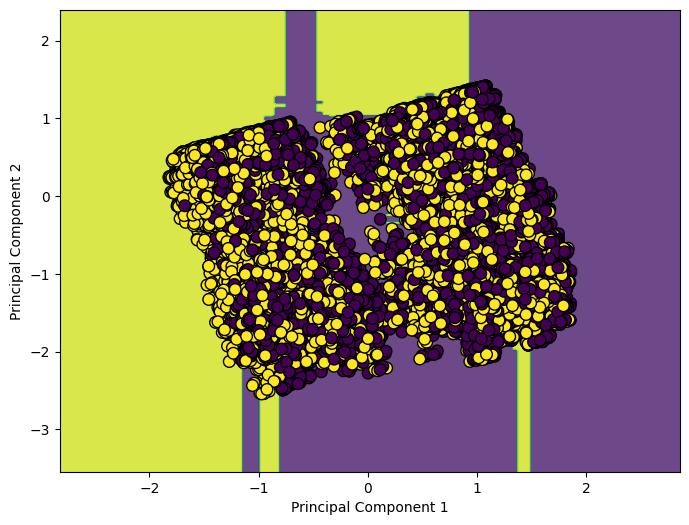

In [20]:
pipeline_rf.fit(X_pca,y_test)
h = .02 
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = pipeline_rf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=.8, cmap=plt.cm.viridis)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c= y_test, s=70, cmap=plt.cm.viridis, edgecolor='k')
plt.xlabel('Principal Component 1', fontsize=10)
plt.ylabel('Principal Component 2', fontsize=10)
plt.show()